In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner, DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
def generate_population(population):
    agents = [
        DoubleTabularQLearner(lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.99)
        for _ in range(population)
    ]

    G = nx.complete_graph(population)

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [3]:
# _, _, G = generate_population(32)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [4]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1)
        if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None else "OTHER"
        for policy in policies
    ]

def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [5]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]

Run 1:   0%|          | 0/5000 [00:00<?, ?it/s]

BEST AGENT (42): 30914 (0.9483936484490398, CCCCCCCCCCCCCDCC)
WORST AGENT (137): 23245 (0.5212994177137603, DCDDCCCCCCCCCCCD)


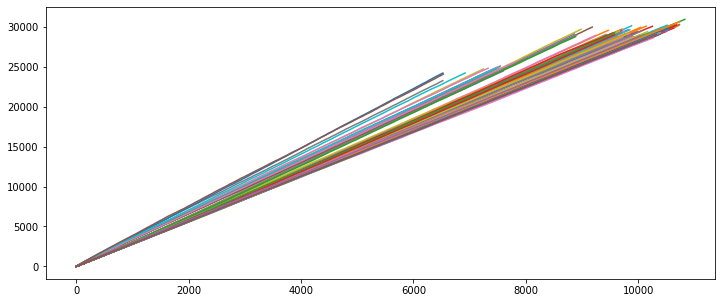

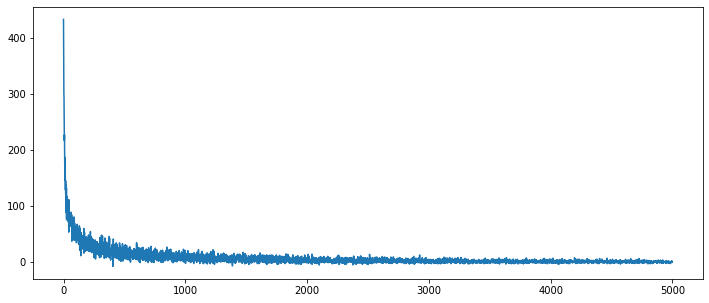

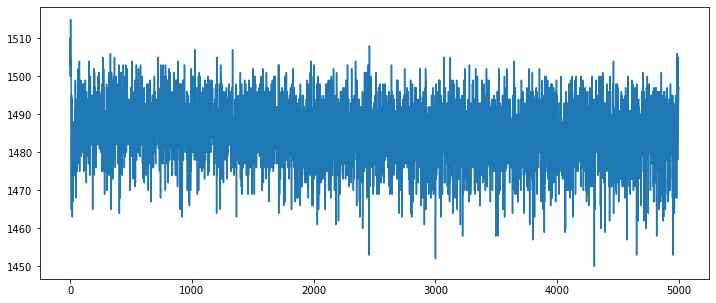

In [6]:
POPULATION = (256,)
ROUNDS = 5_000

run_rewards = []
run_cumulative_rewards = []
run_reward_histories = []
run_policies = []

for run in range(1):
    epoch_rewards = []

    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        r = sim.play_round(train=True)
        epoch_rewards.append(r)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(sim.reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))
    
    plt.show()

    plt.plot(sim.differences)
    plt.show()

    plt.plot(epoch_rewards)
    plt.show()


In [7]:
G = nx.from_numpy_matrix(np.matrix(sim.produce_weight_matrix()), create_using=nx.DiGraph)

In [8]:
# from datetime import datetime

# dt = datetime.isoformat(datetime.now()).replace(":", "-").replace("T", " ")

# nx.drawing.nx_pydot.write_dot(G, f"{dt}.dot")

In [9]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [25]:
M = sim.produce_weight_matrix()

M

array([[0.        , 0.68489893, 0.83769032, ..., 0.45889698, 0.80055402,
        0.05      ],
       [0.68489893, 0.        , 0.84027778, ..., 0.59843361, 0.79719388,
        0.81353326],
       [0.83769032, 0.84027778, 0.        , ..., 0.41710069, 0.84833795,
        0.765625  ],
       ...,
       [0.45889698, 0.59843361, 0.41710069, ..., 0.        , 0.46814404,
        0.93444444],
       [0.80055402, 0.79719388, 0.84833795, ..., 0.46814404, 0.        ,
        0.6553288 ],
       [0.05      , 0.81353326, 0.765625  , ..., 0.93444444, 0.6553288 ,
        0.        ]])

In [28]:
import seaborn as sns

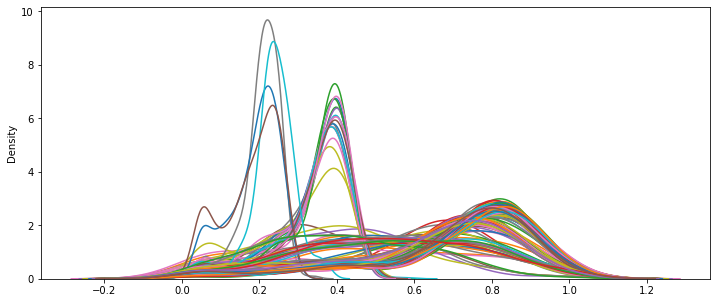

In [29]:
for row in M:
    sns.kdeplot(row)

plt.show()

In [10]:
weights = sim.calculate_weights()

weights

array([[0.05      , 0.68489893, 0.83769032, ..., 0.45889698, 0.80055402,
        0.05      ],
       [0.68489893, 0.05      , 0.84027778, ..., 0.59843361, 0.79719388,
        0.81353326],
       [0.83769032, 0.84027778, 0.05      , ..., 0.41710069, 0.84833795,
        0.765625  ],
       ...,
       [0.45889698, 0.59843361, 0.41710069, ..., 0.05      , 0.46814404,
        0.93444444],
       [0.80055402, 0.79719388, 0.84833795, ..., 0.46814404, 0.05      ,
        0.6553288 ],
       [0.05      , 0.81353326, 0.765625  , ..., 0.93444444, 0.6553288 ,
        0.05      ]])

In [11]:
# K = nx.Graph()
# K.add_weighted_edges_from([
#     (i, j, weights[i, j] + weights[j, i])
#     for i in range(POPULATION[0])
#     for j in range(i + 1, POPULATION[0])
#     if i != j and weights[i, j] > 0.7 and weights[j, i] > 0.7
# ])

# nx.drawing.nx_pydot.write_dot(K, f"{dt} - reduced.dot")

In [12]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>

In [13]:
cumulative_rewards[0][0]

42

In [14]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[2.56801483e+02 1.87316753e+02]
  [2.30925176e+02 2.39250828e+01]
  [2.15186787e+02 1.00242996e+01]
  [4.15201197e+01 5.32625000e-01]]

 [[2.46856168e+02 6.13213539e+01]
  [1.45999966e+02 8.14508973e+00]
  [9.77484380e+01 5.00000000e-02]
  [5.05432158e+00 0.00000000e+00]]

 [[2.44017313e+02 5.44948969e+01]
  [1.17347047e+02 2.07044863e+00]
  [5.05533432e+01 0.00000000e+00]
  [3.75709526e+00 0.00000000e+00]]

 [[1.26880200e+02 4.91936147e+00]
  [0.00000000e+00 5.07605095e+00]
  [8.31868758e+00 0.00000000e+00]
  [1.71602980e+00 0.00000000e+00]]]


In [15]:
agents[cumulative_rewards[4][0]].play_move([Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE])

<Action.COOPERATE: 0>

In [16]:
if hasattr(agents[1], "_q_table"):
    print(agents[1]._q_table)

[[[2.50615283e+02 1.83546278e+02]
  [2.21595363e+02 2.38221290e+01]
  [1.96411284e+02 1.23818463e+01]
  [1.69839049e+01 4.30285329e-01]]

 [[2.39766932e+02 5.35884227e+01]
  [1.26633720e+02 4.20048250e+00]
  [7.28160800e+01 1.36378487e+00]
  [7.59135906e-01 0.00000000e+00]]

 [[2.32604594e+02 4.05720981e+01]
  [9.08703061e+01 3.11857302e+00]
  [5.21564109e+01 1.51519222e+00]
  [8.49313999e-01 2.50000000e-01]]

 [[7.66398404e+01 0.00000000e+00]
  [2.67738888e+01 1.54133086e+00]
  [9.23823369e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]


In [17]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)


In [18]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()}
mean_cumulative_reward_policies = {policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()}

In [19]:
for policy in sorted(mean_cumulative_reward_policy_ranks, key=lambda x: mean_cumulative_reward_policy_ranks[x]):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

10.0                     CCCCCDCCCCDDCCCC
15.0                     CCCCCCCDCCCCDDDC
20.0                     CCCCDDCCCCCCCCCC
25.0                     CCCCCCCCCCCCDDCC
31.0                     CCCCCCCDCCCCCDCC
33.0                     CCCCDCCCDCCCCCCC
36.0                     CDCCCCCDCCCCDCCC
47.0                     CCCDCCCCCCDCCCCC
48.0                     CCCCCDDCCCCCCCCC
59.0                     CCCCCCCDCCCCDCCD
61.0                     CCCDCCCCCDCCCCCC
61.333333333333336       CCCCCCCCCCCDCCCC
64.0                     CCCDCCCCCCCCCCDC
71.0                     CCCCDCDDDDCCCCCC
72.14285714285714        CCCCCCCCCCCCCDCC
75.0                     CCCCCCCCDCCCCCDC
81.0                     CCCCCCCCDCCCCDCC
82.0                     CCCCCCDCDCDCCCCC
84.0                     CCCCCCCCCCCDCDCC
86.25                    CCCCCDCCCCCCCCCC
92.0                     CCDCCCCDCCDCCCCC
95.0                     CDCCCCCCCCCCCCCC
99.0                     CCCCCCCCCCCCDCCC
99.625                   CCCCCCDCC

In [20]:
for policy in sorted(mean_cumulative_reward_policies, key=lambda x: mean_cumulative_reward_policies[x], reverse=True):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

30188.0                  CCCCCDCCCCDDCCCC
30157.0                  CCCCCCCDCCCCDDDC
30071.0                  CCCCDDCCCCCCCCCC
30052.0                  CCCCCCCCCCCCDDCC
29974.0                  CCCCCCCDCCCCCDCC
29948.0                  CCCCDCCCDCCCCCCC
29918.0                  CDCCCCCDCCCCDCCC
29789.714285714286       CCCCCCCCCCCCCDCC
29786.333333333332       CCCCCCCCCCCDCCCC
29771.0                  CCCDCCCCCCDCCCCC
29757.0                  CCCCCDDCCCCCCCCC
29717.0                  CCCCCCCDCCCCDCCD
29713.0                  CCCDCCCCCDCCCCCC
29698.0                  CCCDCCCCCCCCCCDC
29672.0                  CCCCDCDDDDCCCCCC
29662.0                  CCCCCCCCDCCCCCDC
29618.0                  CCCCCDCCCCCCCCCC
29615.0                  CCCCCCCCDCCCCDCC
29610.0                  CCCCCCDCDCDCCCCC
29597.0                  CCCCCCCCCCCDCDCC
29538.0                  CCDCCCCDCCDCCCCC
29534.0                  CDCCCCCCCCCCCCCC
29527.333333333332       CCCCCCCCCCCCDCCC
29520.666666666668       CCCCCCCCC

In [21]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'CCCCCCCCCCCCCDCC'

In [22]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[2.56801483e+02 1.87316753e+02]
  [2.30925176e+02 2.39250828e+01]
  [2.15186787e+02 1.00242996e+01]
  [4.15201197e+01 5.32625000e-01]]

 [[2.46856168e+02 6.13213539e+01]
  [1.45999966e+02 8.14508973e+00]
  [9.77484380e+01 5.00000000e-02]
  [5.05432158e+00 0.00000000e+00]]

 [[2.44017313e+02 5.44948969e+01]
  [1.17347047e+02 2.07044863e+00]
  [5.05533432e+01 0.00000000e+00]
  [3.75709526e+00 0.00000000e+00]]

 [[1.26880200e+02 4.91936147e+00]
  [0.00000000e+00 5.07605095e+00]
  [8.31868758e+00 0.00000000e+00]
  [1.71602980e+00 0.00000000e+00]]]


In [23]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => C
('(C, C)', '(C, D)') => C
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => C
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => C
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => C
('(D, C)', '(C, C)') => C
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => D
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
